# Preliminaries

In [32]:
# import modules
import numpy as np
import sklearn
from sklearn.datasets import load_digits 
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [33]:
# base classes

class Node:
    pass

class Tree:
    def __init__(self):
        self.root = Node()
    
    def find_leaf(self, x):
        node = self.root
        while hasattr(node, "feature"):
            j = node.feature
            if x[j] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node

# Density Tree

<font color=green>**COMMENTS**</font>

- <span style = "color: green; font-weight: bold">We made a permutation of the indices 1,...,D and selected the first D_try ones (instead of selecting the first D_try ones of the valid features). Actually, we should better choose from the valid_features indices only. Our "if left is not None" is not necessary here. In the function calls, we have to include N, too. In the predict function we have to take into account that self.box contains m and M which are both vectors of D dimensions.</span >

- <span style = "color: green; font-weight: bold">Our calculations of the left and right volumes seems to be mostly correct, but the calculation of the sample solution is more concise. We put the calculation of the new bounding boxes already into the loops. In the line `left.data = ...,` one has to add another dimension `[ ... <= t_min, :]`.</span >

- <span style = "color: green; font-weight: bold">node.box is two D-dimensional components m and M. Therefore one more dimension needed: `v = np.prod(node.box[1][:] - node.box[0][:]) = np.prod(M-m)`. The rest is equivalent to the sample solution.</span >

In [34]:
class DensityTree(Tree):
    def __init__(self):
        super(DensityTree, self).__init__()
        
    def train(self, data, prior, n_min=20):
        '''
        data: the feature matrix for the digit under consideration
        prior: the prior probability of this digit
        n_min: termination criterion (don't split if a node contains fewer instances)
        '''
        self.prior = prior
        N, D = data.shape
        D_try = int(np.sqrt(D)) # number of features to consider for each split decision

        # find and remember the tree's bounding box, 
        # i.e. the lower and upper limits of the training feature set
        m, M = np.min(data, axis=0), np.max(data, axis=0)
        self.box = m.copy(), M.copy()
        
        # identify invalid features and adjust the bounding box
        # (If m[j] == M[j] for some j, the bounding box has zero volume, 
        #  causing divide-by-zero errors later on. We must exclude these
        #  features from splitting and adjust the bounding box limits 
        #  such that invalid features have no effect on the volume.)
        valid_features   = np.where(m != M)[0]
        invalid_features = np.where(m == M)[0]
        M[invalid_features] = m[invalid_features] + 1

        # initialize the root node
        self.root.data = data
        self.root.box = m.copy(), M.copy()

        # build the tree
        stack = [self.root]
        while len(stack):
            node = stack.pop()
            n = node.data.shape[0] # number of instances in present node
            if n >= n_min:
                # Call 'make_density_split_node()' with 'D_try' randomly selected 
                # indices from 'valid_features'. This turns 'node' into a split node
                # and returns the two children, which must be placed on the 'stack'.
                
# THIS IS WRONG!!! 
                perm_indices = numpy.random.permutation(valid_features)[:D_try]
# THIS IS THE CORRECTED VERSION:
                perm_indices = numpy.random.permutation(len(valid_features))[:D_try]
                
                left, right = make_density_split_node(node, N, perm_indices)
                stack.append(left)
                stack.append(right)
            else:
                # Call 'make_density_leaf_node()' to turn 'node' into a leaf node.
                make_density_leaf_node(node, N)

    def predict(self, x):
        leaf = self.find_leaf(x)
        # return p(x | y) * p(y) if x is within the tree's bounding box 
        # and return 0 otherwise
        return leaf.response * self.prior if self.box[0] < x < self.box[1] else 0

In [35]:
def make_density_split_node(node, N, feature_indices):
    '''
    node: the node to be split
    N:    the total number of training instances for the current class
    feature_indices: a numpy array of length 'D_try', containing the feature 
                     indices to be considered in the present split
    '''
    n, D = node.data.shape
    m, M = node.box

    # find best feature j (among 'feature_indices') and best threshold t for the split
    e_min = float("inf")
    j_min, t_min = None, None
    m_min, M_min = None, None
    
    for j in feature_indices:
        # Hint: For each feature considered, first remove duplicate feature values using 
        # 'np.unique()'. Describe here why this is necessary.
        print('Necessary because all possible candidate thresholds are mid points between values of neighboring instances!')
        data_unique = np.sort(np.unique(node.data[:, j]))
        # Compute candidate thresholds
        tj = 1/2 * (data_unique[:-1] + data_unique[1:])
        
        # Illustration: for loop - hint: vectorized version is possible
        for t in tj:
            # Compute the error
            Nl = np.sum(node.data[:,j] < tj)
            Nr = np.sum(node.data[:,j] >= tj)
            mj = m.copy()
            Mj = M.copy()
            mj[j] = tj
            Mj[j] = tj
            Vl = np.prod(Mj-m)
            Vr = np.prod(M-mj)
            err1 = Nl/N/Vl * (Nl/N -2*(Nl-1)/(N-1))
            err2 = Nr/N/Vr * (Nr/N -2*(Nr-1)/(N-1))
            loo_error = err1+err2
            
            # choose the best threshold that
            if loo_error < e_min:
                e_min = loo_error
                j_min = j
                t_min = tj
                M_min = Mj
                m_min = mj

    # create children
    left = Node()
    right = Node()
    
    # initialize 'left' and 'right' with the data subsets and bounding boxes
    # according to the optimal split found above
    left.data = node.data[node.data[:, j_min] < t_min] # store data in left node -- for subsequent splits
    left.box = m, M_min # store bounding box in left node
    right.data = node.data[node.data[:, j_min] >= t_min]
    right.box = m_min, M

    # turn the current 'node' into a split node
    # (store children and split condition)
    node.left = left
    node.right = right
    node.feature = j_min
    node.threshold = t_min

    # return the children (to be placed on the stack)
    return left, right

In [36]:
def make_density_leaf_node(node, N):
    '''
    node: the node to become a leaf
    N:    the total number of training instances for the current class
    '''
    # compute and store leaf response
    n = node.data.shape[0]
    v = np.prod(node.box[1] - node.box[0])
    node.response = n/(N*v)

# Decision Tree

<font color = green> **COMMENTS:** </font>

- <font color = green> *Our implementation of Decision Tree is broadly correct and similar to the solution provided, however, the key difference is that in our model the predict() function directly outputs the most likely class label, as the leaf.response stores only the outcome by majority votes, not the probabilities distribtuion of all classes (even though we do have calclated these as posteriors, just not output them explicitly).* </font>

- <font color = green> *Other minor differences are mostly with different python libaries/functions, e.g. solution uses np.argmax(), np.bincount(), whereas we utilized max(set()).* </font>


In [37]:
class DecisionTree(Tree):
    def __init__(self):
        super(DecisionTree, self).__init__()
        
    def train(self, data, labels, n_min=20):
        '''
        data: the feature matrix for all digits
        labels: the corresponding ground-truth responses
        n_min: termination criterion (don't split if a node contains fewer instances)
        '''
        N, D = data.shape
        D_try = int(np.sqrt(D)) # how many features to consider for each split decision

        # initialize the root node
        self.root.data = data
        self.root.labels = labels
        
        stack = [self.root]
        while len(stack): 
            node = stack.pop()    # check the last node on the stack
            
            #print("Node >>> ", node.data.shape)
            
            n = node.data.shape[0]    # number of instances in present node
            if n >= n_min and not node_is_pure(node):
                # Call 'make_decision_split_node()' with 'D_try' randomly selected feature indices. 
                # This turns 'node' into a split node and returns the two children, which must be placed on the 'stack'.
                feature_indices = np.random.permutation(D)[:D_try]
                left, right = make_decision_split_node(node, feature_indices)
                if left is not None:
                    stack.append(left)
                    stack.append(right)
            else:
                # Call 'make_decision_leaf_node()' to turn 'node' into a leaf node.
                if (node.labels.size > 0):
                    make_decision_leaf_node(node)
                
                
    def predict(self, x): # here x is single data point
        
        leaf = self.find_leaf(x)
        # compute p(y | x) --> why do we need this here???
        # posterior = np.sum(leaf.labels==leaf.response)/leaf.N

        return leaf.response #, posterior # your code here

In [38]:
def calc_gini(labels):
    "Calculate gini impurity score for a given set of labels"
    counts = np.unique(labels,return_counts=True)[1]
    gini_impurity = 1-np.square(counts / counts.sum()).sum() 
    
    return gini_impurity


def make_decision_split_node(node, feature_indices):
    '''
    node: the node to be split
    feature_indices: a numpy array of length 'D_try', containing the feature 
                     indices to be considered in the present split
    '''
    n, D = node.data.shape

    # find best feature j (among 'feature_indices') and best threshold t for the split
    j_min, t_min = None, None
    
    gini_parent = calc_gini(node.labels)
    gini_min = gini_parent*n
    
    for j in feature_indices:
        # Hint: For each feature considered, first remove duplicate feature values using 'np.unique()'. 
        # Describe here why this is necessary --> this reduces the computation of looping over all training data to test all the mid-points in-between, where a lot of these pixels are of the same values
        data_unique = np.unique(node.data[:, j])
        
        # Compute candidate thresholds
        tj = ((data_unique[1:]+data_unique[:-1])/2).astype(int)
        
        # Illustration: for loop - hint: vectorized version is possible
        for t in tj:
            left_indices = np.nonzero(node.data[:, j] <= t)[0] 
            right_indices = np.nonzero(node.data[:, j] > t)[0]
            
            # Compute the gini score for children
            gini_left = calc_gini(node.labels[left_indices])
            gini_right = calc_gini(node.labels[right_indices])
            
            # choose the best threshold with minimize the sum of children's gini scores
            if gini_left*len(left_indices) + gini_right*len(right_indices) < gini_min:
                gini_min = gini_left*len(left_indices) + gini_right*len(right_indices)
                j_min = j
                t_min = t
                left_min = left_indices
                right_min = right_indices
            
    # create children
    left = Node()
    right = Node()

    # initialize 'left' and 'right' with the data subsets and labels according to the optimal split found above
    left.data = node.data[left_min,:] # data in left node
    left.labels = node.labels[left_min] # corresponding labels
    right.data = node.data[right_min,:]
    right.labels = node.labels[right_min]

    # turn the current 'node' into a split node (store children and split condition)
    node.left = left
    node.right = right
    node.feature = j_min
    node.threshold = t_min

    # return the children (to be placed on the stack)
    return left, right    



In [39]:
def make_decision_leaf_node(node):
    '''
    node: the node to become a leaf
    '''
    # compute and store leaf response
    node.N = node.labels.size # why do we need this???
    node.response = max(set(node.labels), key=list(node.labels).count)
    posterior = max(np.unique(node.labels,return_counts=True)[1])/node.N
    # print('\tleaf_node: response={},N={},posterior={}'.format(node.response, node.N,posterior))    
    

In [40]:
def node_is_pure(node):
    '''
    check if 'node' ontains only instances of the same digit
    '''
    assert hasattr(node, 'labels'), 'current node has no labels'
    classes = np.unique(node.labels) # returns an array of unique labels, i.e. classes 
    return len(classes) == 1 


# Evaluation of Density and Decision Tree


<font color = green> **COMMENTS:** </font>

- <font color = green> *Minor difference of deriving the confusion matrix: solution uses np.bincount(), whereas we applied the confusion_matrix function from sklearn.metrics.* </font>

- <font color = green> *We have derived similar confusion matrix for Decision Tree at default n_min = 20. However, we forgot to not evaluate for hyperparameter n_min = 10 and 2.*</font>

- <font color = green> *We did not implement the evaluation of Density Tree.*</font>


In [41]:
# read and prepare the digits data
# your code here

from sklearn.datasets import load_digits
digits = load_digits()
data = digits["data"]
labels = digits["target"]

print(data.shape, labels.shape)


(1797, 64) (1797,)


In [42]:
# train trees, plot training error confusion matrices, and comment on your results
# your code here

decision_tree = DecisionTree()
decision_tree.train(data, labels)

Confusion Matrix - Prediction Accuracy Training


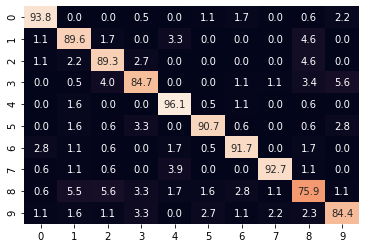

In [43]:

from sklearn.metrics import confusion_matrix

predictions = []
for x in data:
    predictions.append(decision_tree.predict(x))

rebase = np.unique(labels,return_counts=True)[1]
confusion = confusion_matrix(labels, predictions) / rebase *100

from seaborn import heatmap
heatmap(confusion,annot=True,fmt=".1f",cbar=False) 
print("Confusion Matrix - Prediction Accuracy Training")

# Density and Decision Forest

<font color = green> **COMMENTS:** </font>

- <font color = green> *Major differences of deriving a bootstrap sample: solution uses all data at randomized order `np.random.choice(len(data), size=len(data))`, whereas we used only a subset of data $(N_{subset}=N_{total} /e)$ and `np.random.permutation(N_total)[:N_subset]` instead.* </font>

- <font color = green> *We did not implement Density Forest.*</font>


In [44]:
class DecisionForest():
    def __init__(self, n_trees):
        # create ensemble
        self.trees = [DecisionTree() for i in range(n_trees)]
        self.n_trees = n_trees
    
    def train(self, data, labels, n_min=0):
        N_total = len(labels)
        N_subset = int(0.368*N_total)
        for tree in self.trees:
            # train each tree, using a bootstrap sample of the data
            subset_indices = np.random.permutation(N_total)[:N_subset]
            tree.train(data[subset_indices], labels[subset_indices])
            
    def predict(self, x):
        # compute the ensemble prediction
        prediction = []
        for tree in self.trees:
            prediction.append(tree.predict(x))
        
        result = max(set(prediction), key=prediction.count)
        return result # your code here

# Evaluation of Density and Decision Forest

<font color = green> **COMMENTS:** </font>

- <font color = green> *We have derived similar conclusion based on confusion matrix for Decision Tree that ensembles improve the performance in comparison to the single tree.*</font> 

- <font color = green> *However, we forgot to evaluate for different hyperparameter n_min = 10 and 2 for example.*</font>


Confusion Forest - Prediction Accuracy Training


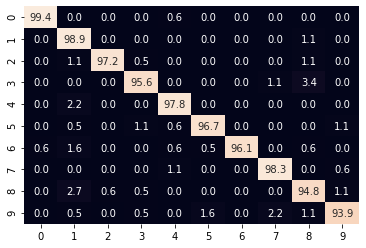

In [45]:
# train forests (with 20 trees per forest), plot training error confusion matrices, and comment on your results
# your code here

decision_forest = DecisionForest(n_trees=20)

decision_forest.train(data, labels)

predictions = []
for x in data:
    predictions.append(decision_forest.predict(x))

rebase = np.unique(labels,return_counts=True)[1]
confusion_forest = confusion_matrix(labels, predictions) / rebase *100

heatmap(confusion_forest,annot=True,fmt=".1f",cbar=False) 
print("Confusion Forest - Prediction Accuracy Training")